# Results - Regression on Synthetic Data

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/berni-lehner/structural_health_monitoring/blob/main/notebooks/synthetic_regression_results.ipynb)

## Prerequisites

In [1]:
import sys
import os
import time
import glob
from pathlib import Path
import sklearn
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets


# initialize environment, paths, etc...
IN_COLAB = 'google.colab' in sys.modules

if(IN_COLAB):
    # uncomment in case you want to start from scratch in Colab
    !rm -rf /content/structural_health_monitoring  
    !git clone https://github.com/berni-lehner/structural_health_monitoring.git
    !pip install -r /content/structural_health_monitoring/requirements.txt
    
    # this is Colab specific, and only a manual "Run all" will cause the
    # installation to be finished
    if(pd.__version__ != '1.4.2'):
      print('Stopping RUNTIME! Please run again to finish installation.')
      os.kill(os.getpid(), 9)

    DATA_PATH = Path(r"/content/structural_health_monitoring/data")
    sys.path.insert(0, "/content/structural_health_monitoring/src")
else:
    DATA_PATH = Path(r"../data/")
    sys.path.insert(0,"../src")
    
    
sys.path.insert(0, DATA_PATH)
SYN_DATA_PATH = Path(DATA_PATH, "synthetic")
REAL_DATA_PATH = Path(DATA_PATH, "real_world")
RESULT_PATH = Path(DATA_PATH, "results")
if not os.path.isdir(RESULT_PATH):
    os.makedirs(RESULT_PATH)

try:
    from zippeekiyay import namelist
except ImportError or ModuleNotFoundError:
    print('installing zippee-ki-yay...')
    !pip install git+https://github.com/berni-lehner/zippee-ki-yay.git

    from zippeekiyay import namelist

CALIBRATION_FILE = Path(REAL_DATA_PATH, "calibration.pkl")

In [2]:
from plot_utils import (
    init_plotting,
    plot_metrics,
    plot_metrics_bar,
    get_metrics_summary,
    plot_cv_indices)

# configure fonts, etc...
init_plotting()

from scoring_utils import (
    get_synth_regression_scoring,
    SHM_Scoring)

from bench_utils import extract_metrics

## Data Loading

In [3]:
result_file = "synthetic_regression_AA_baseline.pkl"
result_file = Path(RESULT_PATH, result_file)

syn_reg_baseline = pd.read_pickle(result_file)

In [4]:
result_file = "synthetic_regression_AB.pkl"
result_file = Path(RESULT_PATH, result_file)

syn_reg = pd.read_pickle(result_file)

In [5]:
syn_reg.head()

,fit_time,score_time,test_r2 avg,test_neg_mean_squared_error avg,test_r2_0.0,test_r2_2.8,test_r2_3.1,test_r2_3.4,test_r2_3.8,test_r2_4.1,...,test_abs_err_22.0,test_abs_err_24.0,test_abs_err_26.0,test_abs_err_28.0,test_abs_err_30.0,test_abs_err_32.0,test_abs_err_34.0,test_abs_err_36.0,test_abs_err_38.0,test_abs_err_40.0
0,0.078787,2.833420,0.999971,-0.004599,1.0,-1.071035e+29,-1.075582e+28,-4.417174e+28,0.0,-4.494986e+27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.038894,2.855362,0.999970,-0.004684,1.0,-9.313351e+28,-6.658367e+27,-2.665987e+28,0.0,-2.619380e+27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.090756,2.791534,0.999976,-0.003787,1.0,-7.450681e+28,-9.219277e+27,-2.051764e+28,0.0,-2.037296e+27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.030917,3.359014,0.999966,-0.005440,1.0,-1.117602e+29,-1.229237e+28,-3.920569e+28,0.0,-2.619380e+27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.022938,3.310146,0.999975,-0.003953,1.0,-9.779019e+28,-1.075582e+28,-3.293278e+28,0.0,-2.328338e+27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Combine results from baseline and our models

In [6]:
results = pd.concat([syn_reg_baseline[syn_reg_baseline['model'] == 'BASE_0'],
                     syn_reg[syn_reg['model'] == 'KNN_1'],
                     syn_reg[syn_reg['model'] == 'SVR'],
                     syn_reg[syn_reg['model'] == 'MLP_48'],
                     syn_reg[syn_reg['model'] == 'MLP_64.32']],
                     ignore_index=True)

In [7]:
results.head()

,fit_time,score_time,test_r2 avg,test_neg_mean_squared_error avg,test_r2_0.0,test_r2_2.8,test_r2_3.1,test_r2_3.4,test_r2_3.8,test_r2_4.1,...,test_abs_err_22.0,test_abs_err_24.0,test_abs_err_26.0,test_abs_err_28.0,test_abs_err_30.0,test_abs_err_32.0,test_abs_err_34.0,test_abs_err_36.0,test_abs_err_38.0,test_abs_err_40.0
0,0.413888,3.185458,0.982096,-2.834599,0.0,-9.939416e+29,-1.107451e+29,-3.067192e+29,0.0,-5.212890e+28,...,1.967205,0.000000,3.195309,2.414265,2.593870,0.000000,3.228801,3.499271,0.000000,3.614632
1,0.410903,3.184453,0.985359,-2.317990,0.0,-6.529694e+29,-7.756713e+28,-2.226883e+29,0.0,-6.131290e+28,...,0.000000,0.000000,3.245171,1.616244,0.202031,3.482859,0.000000,4.405748,0.000000,2.233762
2,0.428851,3.220362,0.974569,-4.026242,0.0,-1.185383e+30,-1.496710e+29,-4.638033e+29,0.0,-5.542738e+28,...,0.000000,0.000000,2.132227,3.307212,2.808224,4.141928,4.685402,2.030381,0.000000,5.047292
3,0.452787,3.053831,0.976395,-3.737202,0.0,-5.484529e+29,-9.048550e+28,-2.130176e+29,0.0,-3.948473e+28,...,0.000000,0.000000,0.000000,2.880193,0.202031,0.000000,0.000000,4.329349,0.000000,7.350328
4,0.471738,3.089734,0.977633,-3.541088,0.0,-1.063274e+30,-6.977058e+28,-1.849202e+29,0.0,-3.841757e+28,...,1.979925,2.111219,1.624554,1.616244,1.829464,0.000000,4.544726,4.372374,3.398667,4.061385


In [8]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Columns: 206 entries, fit_time to test_abs_err_40.0
dtypes: float64(176), int32(29), object(1)
memory usage: 239.5+ KB


## Add relative contribution to full average MSE
Notice that in case of class imbalance, the class distribution has to be considered additionally!

In [9]:
shm_scoring = SHM_Scoring()

# source columns
mse_individual = ['test_mse_0.0'] + shm_scoring.SYNTH_MSE_RESULTS
mse_individual

['test_mse_0.0',
 'test_mse_2.2',
 'test_mse_2.5',
 'test_mse_2.8',
 'test_mse_3.1',
 'test_mse_3.4',
 'test_mse_3.8',
 'test_mse_4.1',
 'test_mse_4.4',
 'test_mse_4.7',
 'test_mse_5.0',
 'test_mse_6.7',
 'test_mse_8.3',
 'test_mse_10.0',
 'test_mse_12.0',
 'test_mse_14.0',
 'test_mse_16.0',
 'test_mse_18.0',
 'test_mse_20.0',
 'test_mse_22.0',
 'test_mse_24.0',
 'test_mse_26.0',
 'test_mse_28.0',
 'test_mse_30.0',
 'test_mse_32.0',
 'test_mse_34.0',
 'test_mse_36.0',
 'test_mse_38.0',
 'test_mse_40.0']

In [10]:
# target columns
mse_contr_individual = [item.replace('test_mse_', 'mse_contr_') for item in mse_individual]
mse_contr_individual

['mse_contr_0.0',
 'mse_contr_2.2',
 'mse_contr_2.5',
 'mse_contr_2.8',
 'mse_contr_3.1',
 'mse_contr_3.4',
 'mse_contr_3.8',
 'mse_contr_4.1',
 'mse_contr_4.4',
 'mse_contr_4.7',
 'mse_contr_5.0',
 'mse_contr_6.7',
 'mse_contr_8.3',
 'mse_contr_10.0',
 'mse_contr_12.0',
 'mse_contr_14.0',
 'mse_contr_16.0',
 'mse_contr_18.0',
 'mse_contr_20.0',
 'mse_contr_22.0',
 'mse_contr_24.0',
 'mse_contr_26.0',
 'mse_contr_28.0',
 'mse_contr_30.0',
 'mse_contr_32.0',
 'mse_contr_34.0',
 'mse_contr_36.0',
 'mse_contr_38.0',
 'mse_contr_40.0']

In [11]:
full_mse = results[mse_individual].sum(axis=1)/len(mse_individual)

for col in results[mse_individual]:
    tmp = results[col]*100/len(mse_individual)/full_mse
    results[col.replace('test_mse_', 'mse_contr_')] = tmp
    
# sanity check, all contributions have to sum up to 100% every time for each defect
assert results[mse_contr_individual].sum(axis=1).sum()/len(results)==100

## Plot MSE

In [12]:
axis_font = {#'family': 'Times',
        'color':  'black',
        'weight': 'bold',
        'size': 24,
        }

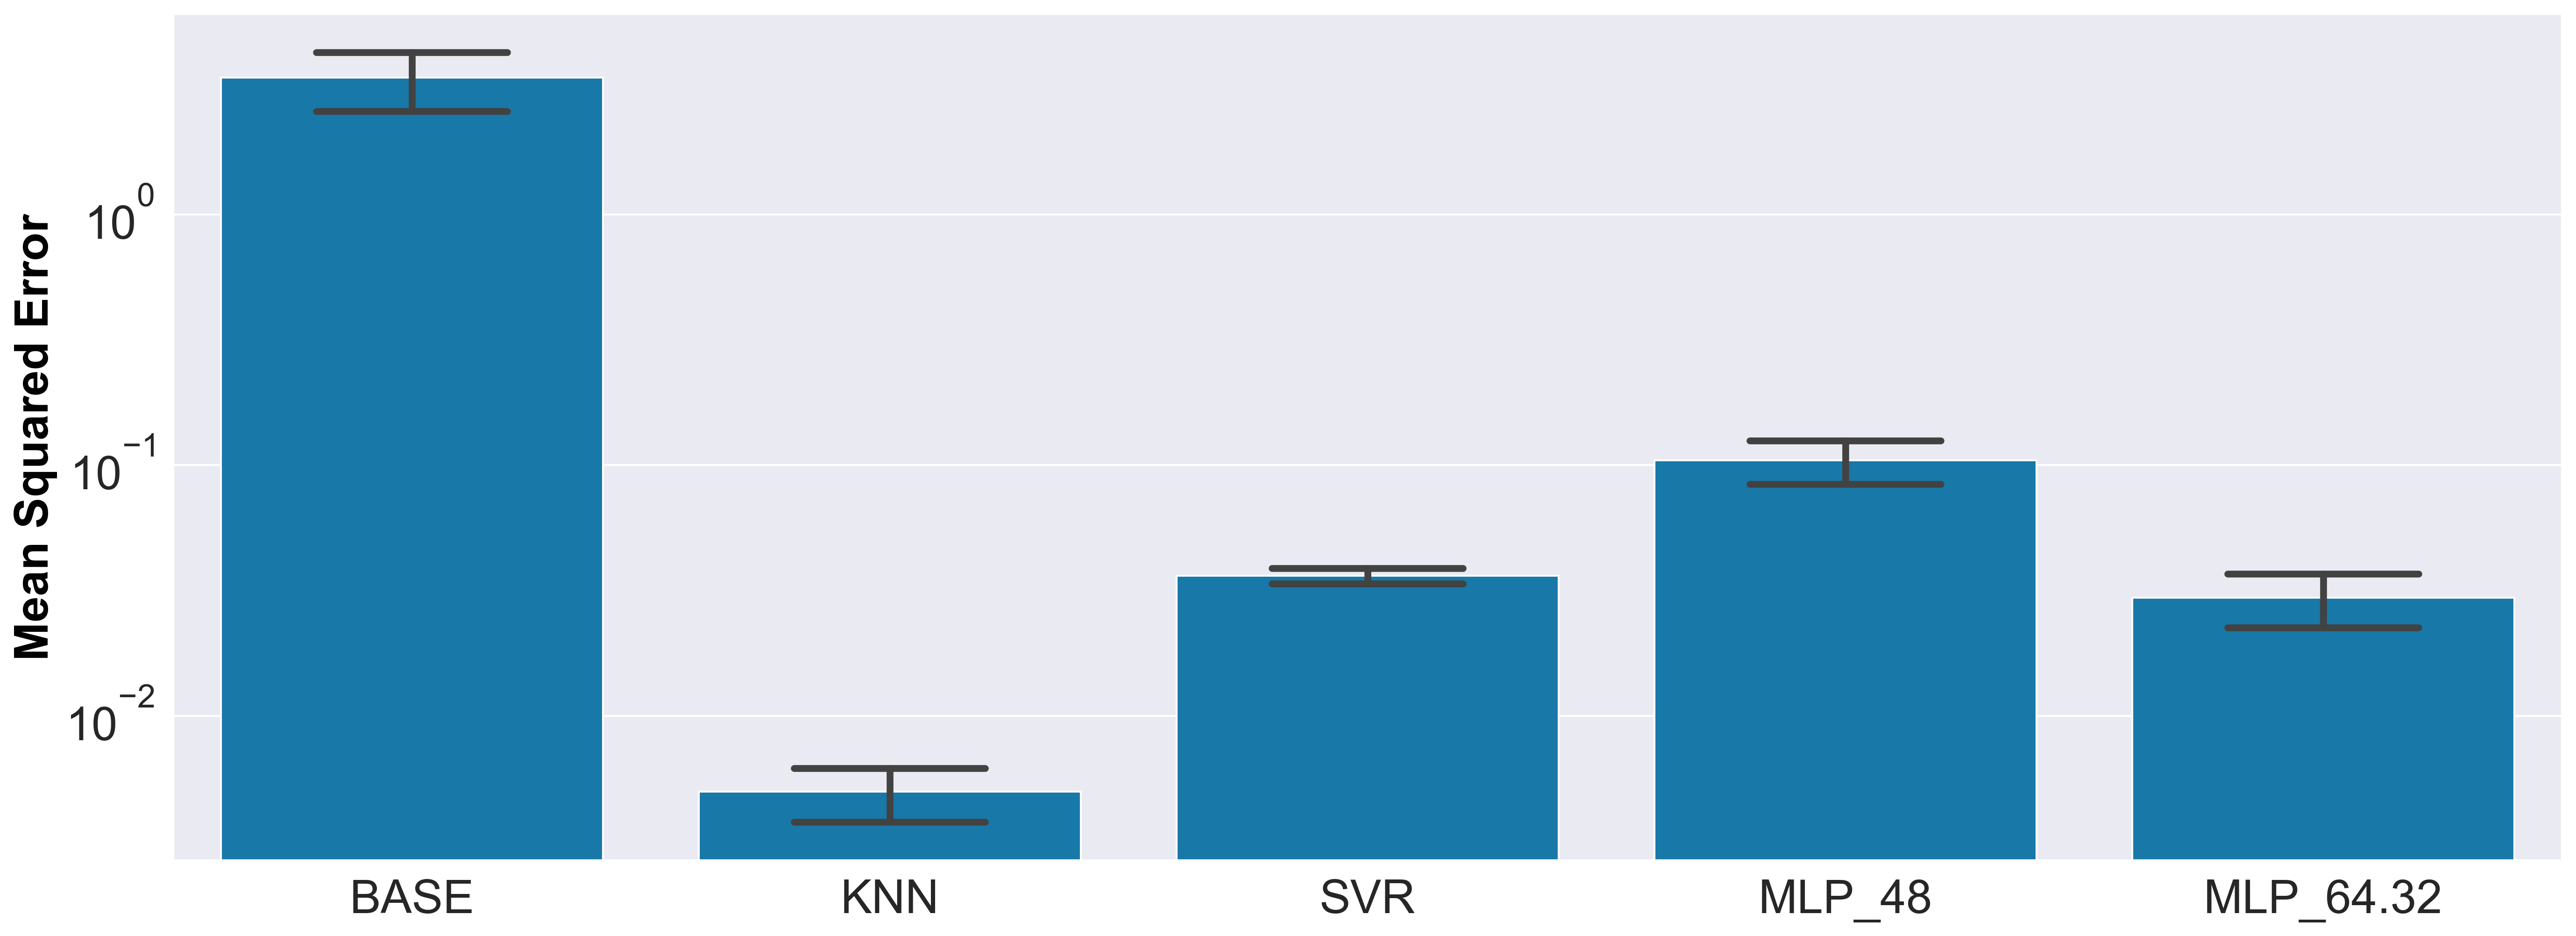

In [13]:
df = extract_metrics(results, ['test_mse_0.0_40.0'])
                     
fig = plot_metrics_bar(df,
                       palette='winter',
                       errwidth=3.5,
                       capsize=.4)

plt.yscale("log")
plt.ylabel('Mean Squared Error', fontdict=axis_font)
plt.xlabel('')
fig.get_legend().remove()

labels = [item.get_text() for item in plt.gca().get_xticklabels()]
labels[0] = 'BASE'
labels[1] = 'KNN'
plt.gca().set_xticklabels(labels)

fname = Path(RESULT_PATH, r"synth_regr_mse.pdf")
plt.savefig(fname, bbox_inches='tight')
plt.show()

In [14]:
get_metrics_summary(df)

,,mean,std
model,metrics,,
BASE_0,test_mse_0.0_40.0,3.507287,0.941129
KNN_1,test_mse_0.0_40.0,0.004972,0.001225
MLP_48,test_mse_0.0_40.0,0.104566,0.020897
MLP_64.32,test_mse_0.0_40.0,0.029616,0.007263
SVR,test_mse_0.0_40.0,0.036123,0.002598


## Plot MSE wrt Defect Size

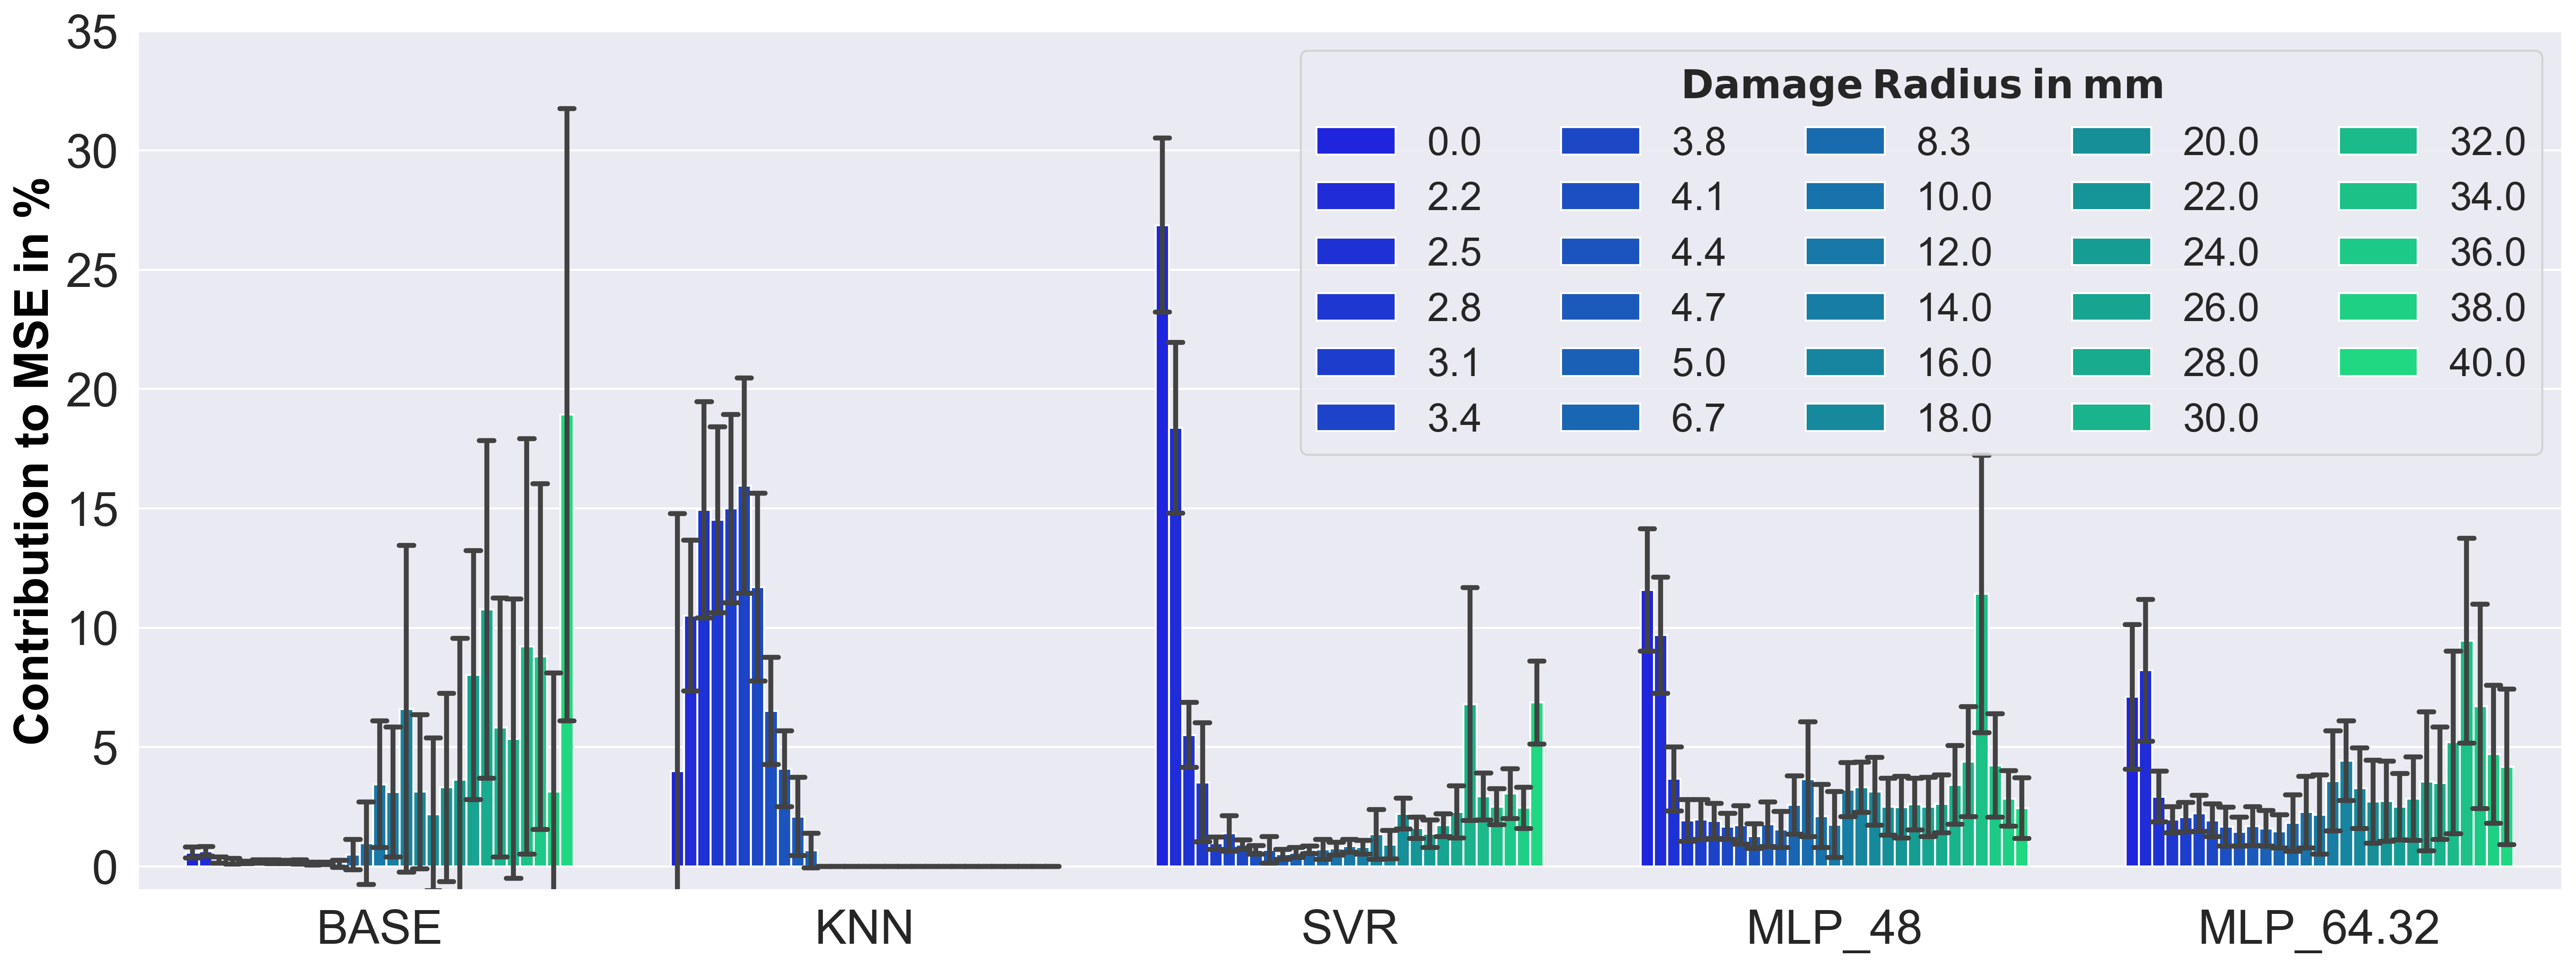

In [15]:
df = extract_metrics(results, mse_contr_individual)

fig = plot_metrics_bar(df,
                       palette='winter',
                       errwidth=2.5,
                       capsize=.03)
plt.ylim((-1,35))
plt.ylabel('Contribution to MSE in %', fontdict=axis_font)
plt.xlabel('')

handles, labels = plt.gca().get_legend_handles_labels()
new_labels = [item.replace('mse_contr_', '') for item in labels]
plt.legend(handles, new_labels, ncol=5, loc='best',
           title="$\\bf{Damage \:Radius} \:in\:mm$",
           title_fontsize=20, fontsize=20)

labels = [item.get_text() for item in plt.gca().get_xticklabels()]
labels[0] = 'BASE'
labels[1] = 'KNN'
plt.gca().set_xticklabels(labels)

fname = Path(RESULT_PATH, r"synth_regr_mse_individual_contribution.pdf")
plt.savefig(fname, bbox_inches='tight')
plt.show()

In [16]:
get_metrics_summary(df)

mean       std
model  metrics                           
BASE_0 mse_contr_0.0   0.581802  0.230822
       mse_contr_10.0  0.971894  1.760496
       mse_contr_12.0  3.442504  2.693188
       mse_contr_14.0  3.116808  2.766823
       mse_contr_16.0  6.606769  6.949022
...                         ...       ...
SVR    mse_contr_4.7   0.510512  0.210115
       mse_contr_40.0  6.865907  1.763330
       mse_contr_5.0   0.583229  0.208497
       mse_contr_6.7   0.699614  0.158318
       mse_contr_8.3   0.717430  0.426178

[145 rows x 2 columns]

In [17]:
df = extract_metrics(results, ['score_time'])

In [18]:
get_metrics_summary(df)

,,mean,std
model,metrics,,
BASE_0,score_time,2.978688,0.231200
KNN_1,score_time,3.056330,0.351607
MLP_48,score_time,0.019916,0.002142
MLP_64.32,score_time,0.022253,0.002674
SVR,score_time,2.215360,0.752932
